In [1]:
from s3ts.data.tasks.download import download_dataset
from sklearn.model_selection import StratifiedKFold, train_test_split
from s3ts.experiments import prepare_dms
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np

/home/rcoterillo/repos/s3ts/s3ts_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

In [3]:
# setup to recreate the folds used in the experiments

dataset = "GunPoint"
random_state = 0
fold, total_folds = 0, 5
dir_cache=Path("../cache/")

X, Y, mapping = download_dataset(dataset_name=dataset, dir_cache=dir_cache)
X, _, Y, _ = train_test_split(X, Y, stratify=Y, test_size=0.9, random_state=0)


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
for j, (train_index, test_index) in enumerate(skf.split(X, Y)):
  if j == fold:
    X_train, Y_train = X[train_index,:], Y[train_index]
    X_test, Y_test = X[test_index,:], Y[test_index]

train_dm, pretrain_dm = prepare_dms(dataset=dataset,
  X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test,
  batch_size=128, window_length=5, window_stride=1, rho_dfs=0.1, pret_frac=1 - 1/(total_folds-1), 
  quant_shifts=[0], quant_intervals=5, fold_number=fold, 
  random_state=random_state, frames=True, dir_cache=dir_cache)

In [4]:
train_dm.ds_train[1]

(tensor([[[-1.5829, -1.5788, -1.5718, -1.5631, -1.5535, -1.5440],
          [-1.5829, -1.5788, -1.5719, -1.5631, -1.5535, -1.5440],
          [-1.5829, -1.5788, -1.5719, -1.5632, -1.5536, -1.5441],
          ...,
          [ 2.6717,  2.6130,  2.5581,  2.5060,  2.4557,  2.4062],
          [ 2.6724,  2.6137,  2.5588,  2.5067,  2.4563,  2.4069],
          [ 2.6730,  2.6143,  2.5594,  2.5073,  2.4569,  2.4074]],
 
         [[-1.4124, -1.4078, -1.4060, -1.4060, -1.4068, -1.4077],
          [-1.4139, -1.4095, -1.4078, -1.4079, -1.4089, -1.4100],
          [-1.4132, -1.4088, -1.4071, -1.4072, -1.4082, -1.4092],
          ...,
          [ 3.2055,  3.0699,  2.9381,  2.8510,  2.7847,  2.7196],
          [ 3.2120,  3.0738,  2.9394,  2.8515,  2.7852,  2.7200],
          [ 3.2186,  3.0778,  2.9407,  2.8519,  2.7856,  2.7205]]]),
 tensor([1, 0]))

In [5]:
pretrain_dm.DFS_train

tensor([[[1.7612e-01, 3.4735e-01, 5.1241e-01,  ..., 5.6586e+01,
          5.5931e+01, 5.5269e+01],
         [3.5230e-01, 3.4742e-01, 5.1247e-01,  ..., 5.6584e+01,
          5.5928e+01, 5.5267e+01],
         [5.2798e-01, 5.2041e-01, 5.1203e-01,  ..., 5.6577e+01,
          5.5922e+01, 5.5260e+01],
         ...,
         [1.7057e+02, 1.6797e+02, 1.6542e+02,  ..., 1.2047e+01,
          1.2078e+01, 1.2094e+01],
         [1.7082e+02, 1.6822e+02, 1.6566e+02,  ..., 1.2113e+01,
          1.2144e+01, 1.2159e+01],
         [1.7107e+02, 1.6846e+02, 1.6590e+02,  ..., 1.2151e+01,
          1.2206e+01, 1.2220e+01]],

        [[1.4656e-01, 2.9309e-01, 4.4095e-01,  ..., 7.1774e+01,
          7.0797e+01, 6.9851e+01],
         [2.8854e-01, 2.8851e-01, 4.3187e-01,  ..., 7.1474e+01,
          7.0497e+01, 6.9550e+01],
         [4.5175e-01, 4.4956e-01, 4.5309e-01,  ..., 7.1495e+01,
          7.0518e+01, 6.9572e+01],
         ...,
         [1.8159e+02, 1.7883e+02, 1.7611e+02,  ..., 8.9939e+00,
          8.879

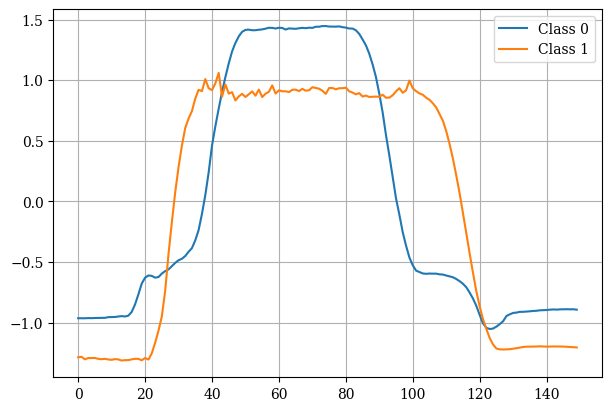

In [6]:
plt.figure(figsize=(6,4), layout="constrained")
for i in range(train_dm.patterns.shape[0]):
    plt.plot(train_dm.patterns[i], label=f"Class {i}")
plt.grid(True)
plt.legend();

/tmp/ipykernel_57749/761194953.py:23: RuntimeWarning: overflow encountered in exp
  exp_func = lambda t,a,b: a*np.exp(-b*t)


27


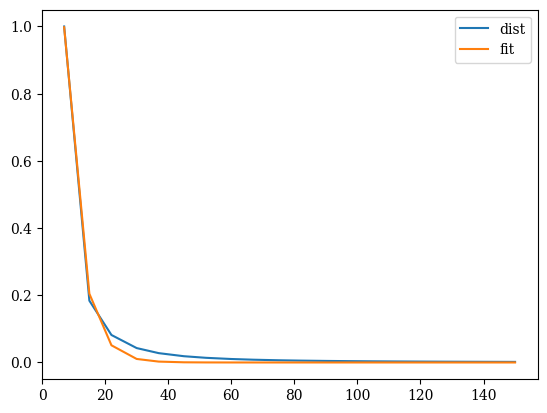

In [7]:
from sktime.distances import dtw_distance
from scipy.interpolate import splev, splrep

pattern = 1

dist = []
samples = np.linspace(train_dm.patterns.shape[1]/20, train_dm.patterns.shape[1], 20, dtype=int)
for i in samples:
    x = np.arange(train_dm.patterns.shape[1])
    series = train_dm.patterns[pattern].numpy()

    spl = splrep(x, series)

    x_comp = np.linspace(0,train_dm.patterns.shape[1], num=i)
    series_comp = splev(x_comp, spl)
    dist.append(dtw_distance(x, x_comp))
dist = np.array(dist)
dist = dist/dist.max()
plt.plot(samples, dist, label="dist")

from scipy.optimize import curve_fit

exp_func = lambda t,a,b: a*np.exp(-b*t)
popt, pcov = curve_fit(exp_func, samples, dist)

plt.plot(samples, exp_func(samples, *popt), label="fit")
plt.legend()
optimal = int(8*np.log(2)/popt[1])
print(optimal)

415.97633136094714


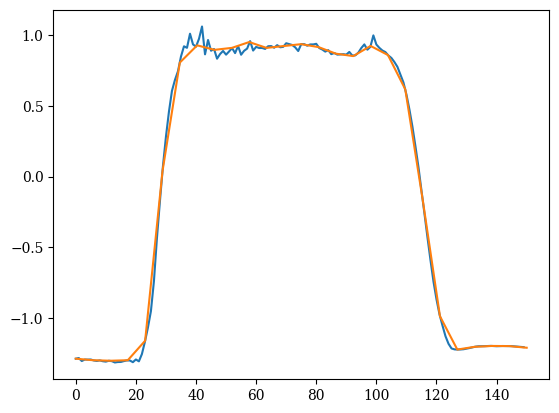

In [8]:
x = np.arange(train_dm.patterns.shape[1])
series = train_dm.patterns[pattern].numpy()

spl = splrep(x, series)

x_comp = np.linspace(0,train_dm.patterns.shape[1], num=optimal)
series_comp = splev(x_comp, spl)

plt.plot(x, series)
plt.plot(x_comp, series_comp)
print(dtw_distance(x, x_comp))

In [9]:
def smooth_STS(
        STS: np.ndarray,
        n_sample: int,
        l_sample: int,
        ) -> np.ndarray:

    STS = pd.Series(STS)
    XD = pd.Series(STS).rolling(5).mean()

    positions = np.arange(0,n_sample)*l_sample
    #print(positions)

    spacing = int(l_sample/10)
    
    for idx in positions[1:]:

        # moving averages
        


        # # using splinesss
        # idx_range = [
        #     idx-spacing,
        #     idx-spacing+1, 
        #     idx+spacing-2,
        #     idx+spacing-1,
        #     ]
        # series = [
        #     XD.iloc[idx-spacing],
        #     XD.iloc[idx-spacing+1],
        #     XD.iloc[idx+spacing-2],
        #     XD.iloc[idx+spacing-1]
        #     ]
        # spl = splrep(idx_range, series)
        # idx_range = np.arange(idx-spacing, idx+spacing)
        # STS.iloc[idx-spacing:idx+spacing] = splev(idx_range, spl)


        pass


    return STS.values

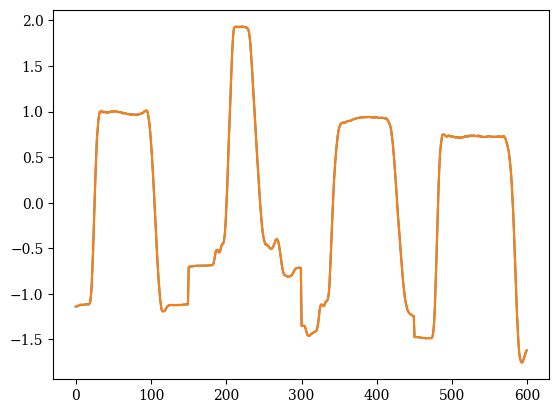

In [10]:
dm = pretrain_dm
TS = dm.STS_train
LP = dm.l_patterns
NS = int(dm.STS_train.shape[0]/LP)

samples = 4

plt.plot(TS[0:samples*LP])
plt.plot(smooth_STS(TS, NS, LP)[0:samples*LP])

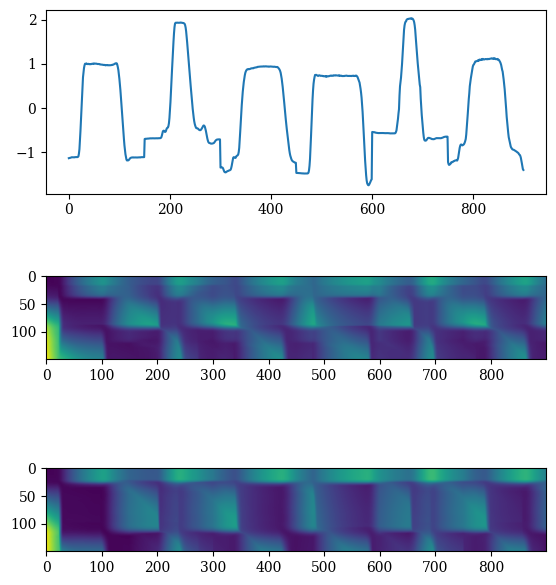

In [11]:
dm = pretrain_dm

TS = dm.STS_train
DFS = dm.DFS_train
CLS = dm.labels_train.argmax(dim=1)
NCLS = dm.n_labels
LP = dm.l_patterns
NP = dm.n_patterns

samples = 6

fig = plt.figure(figsize=(6, 2*(NP+1)), dpi=100, layout="constrained")
gs = fig.add_gridspec(nrows=NP+1, ncols=2,
    hspace=0, height_ratios=None,
    wspace=0, width_ratios=[0.1, 0.9])

axes = {}

axes["TS"] = fig.add_subplot(gs[0,1])
axes["TS"].plot(TS[0:samples*LP])

for i in range(NP):
    axes[i] = fig.add_subplot(gs[i+1,1])
    axes[i].imshow(DFS[i,:,0:samples*LP])



In [12]:
NCLS

5